In [57]:
import os

import scipy.interpolate
from astropy.visualization import ZScaleInterval
from scipy.interpolate import UnivariateSpline

os.environ['CRDS_PATH'] = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS/"
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

import stdatamodels.jwst.datamodels as dm
import numpy as np
import matplotlib.pyplot as plt
import BNBG.Pipeline.BetterBackgroundSubtractStep as BBStep
from scipy.ndimage import median_filter
from scipy.stats import median_abs_deviation as mad

In [2]:
path = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/jw01345063001_03101_00003_nrs2_resamplespecstep_temp.fits"
model = dm.open(path)

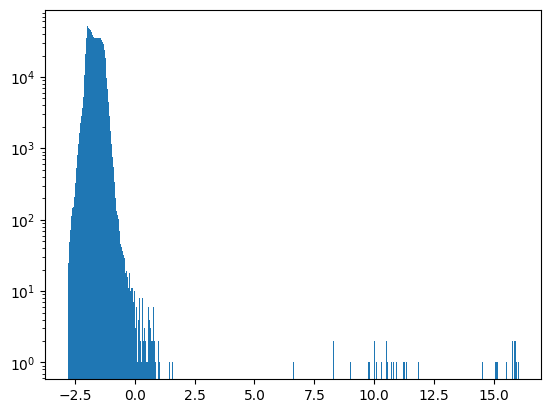

In [3]:
err = np.array([])

for i, slit in enumerate(model.slits):
	err = np.append(err, slit.err.ravel())

err = err[np.isfinite(err)]
plt.figure()
plt.hist(np.log10(err), bins=500)
plt.yscale('log')
plt.show()

2024-12-18 14:51:10,037 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:177: RuntimeWarning: All-NaN slice encountered
  medianData = generic_filter(data, lambda x : np.nanmedian(x), size=kernelSize, mode="nearest")

2024-12-18 14:51:10,097 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:178: RuntimeWarning: All-NaN slice encountered
  medianError = generic_filter(error, lambda x : np.nanmedian(x), size=kernelSize, mode="nearest")

2024-12-18 14:51:10,157 - stpipe - WARNING - /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:269: RuntimeWarning: Mean of empty slice
  x = np.nanmean(data,axis=0)

2024-12-18 14:51:10,177 - stpipe - INFO -  - [BetterBackground]  : Finished Interpolation with 21 iterations, found S = 0.019024372100830078


0 0 1 403 2
1 0 0.5 403 2
2 0 0.25 403 2
3 0 0.125 403 2
4 0 0.0625 403 2
5 0 0.03125 403 2
6 0 0.015625 403 2
7 0 0.0078125 403 2
8 0 0.00390625 403 2
9 0 0.001953125 403 2
10 0 0.0009765625 403 2
11 0 0.00048828125 403 2
12 0 0.000244140625 403 2
13 0 0.0001220703125 403 2
14 0 6.103515625e-05 403 6
15 3.0517578125e-05 6.103515625e-05 47 6
16 4.57763671875e-05 6.103515625e-05 21 6
17 4.57763671875e-05 5.340576171875e-05 21 11
18 4.57763671875e-05 4.9591064453125e-05 21 16
19 4.57763671875e-05 4.76837158203125e-05 21 19
20 4.673004150390625e-05 4.76837158203125e-05 21 19


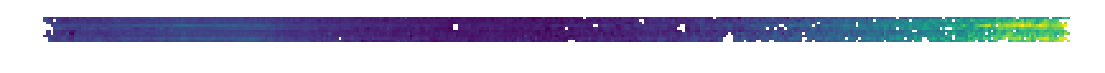

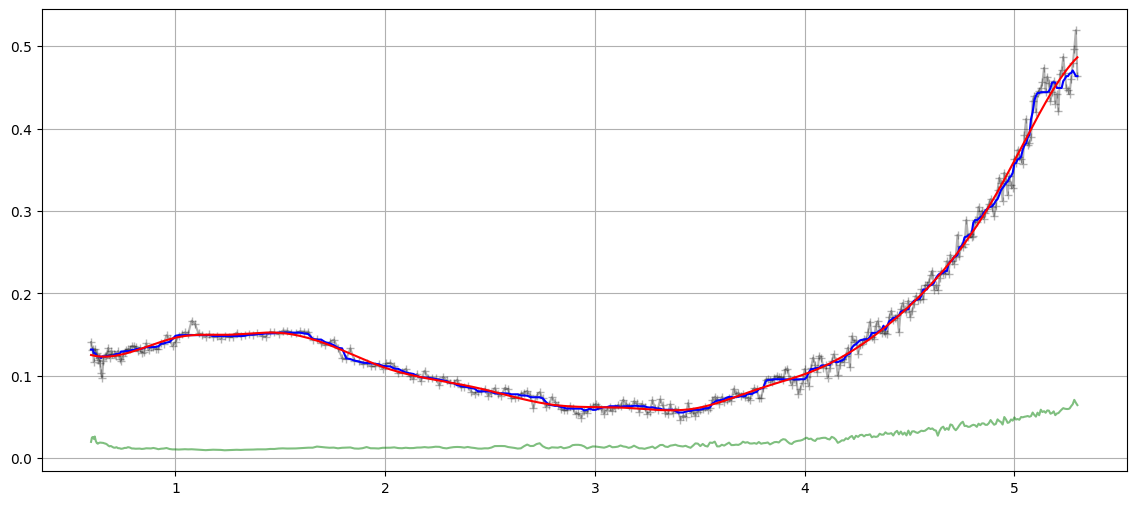

In [4]:

for i,slit in enumerate(model.slits):
	if i != 2:
		continue
	data = slit.data.copy()
	error = slit.err.copy()
	Y, X = np.indices(slit.data.shape)
	_, _, wavelength = slit.meta.wcs.transform("detector", "world", X, Y)
	source = BBStep.getSourcePosition(slit)

	x,y,dy = BBStep.getDataWithMask(data, error, wavelength, source=source)

	median = median_filter(y,size=15)

	plt.figure(figsize=(14,2))
	plt.imshow(data, origin='lower', cmap='viridis', interpolation='none')
	plt.axis('off')

	plt.figure(figsize=(14,6))
	plt.plot(x,y,marker='+',alpha=0.3,color='k')
	plt.plot(x,dy,alpha=0.5,color='g')
	plt.plot(x,median,color='b')
	plt.grid()

	w = 1/dy
	w /= w.mean()
	interp = BBStep.makeInterpolation(x, y, w,n=0.05)

	plt.plot(x,interp(x),color='r')

	plt.show()

In [5]:
from scipy.ndimage import generic_filter

# Custom function to compute the median, ignoring NaNs
def nanmedian_filter(values):
    return np.nanmedian(values)

def masking(data, error, crop=3, source=None, radius=5, percent=99):
	origdata = np.copy(data)

	fig ,ax = plt.subplots(6,1,figsize=(18,8), gridspec_kw={'height_ratios': [1, 1, 1, 1, 3, 3]})
	plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, hspace=0)

	z1, z2 = ZScaleInterval().get_limits(data)
	ax[0].imshow(origdata, origin='lower', cmap='grey', interpolation='none', vmin=z1, vmax=z2, zorder=-1)

	Y, X = np.indices(data.shape)
	# Gets rid of negative values, crops the top and bottom of the image, ignores pixels marked as nan

	mask = (data <= 0) | (Y < crop) | (Y > Y.max() - crop) | np.isnan(data)

	# If source in the image, remove lines in a radius around
	# This also works if the source is not in frame and the returned position is 1e48
	if source is not None:
		mask = mask | (np.round(abs(Y - source)) < radius)

	# Removes top 1% highest error values in already kept values
	error[mask] = np.nan
	median_err = generic_filter(error, nanmedian_filter, size=(1,15), mode="nearest")
	img_err = error - median_err
	median_err_values = img_err.ravel()
	median_err_values = median_err_values[np.isfinite(median_err_values)]
	std_err = 10*mad(median_err_values)
	mask = mask | (np.abs(img_err) > std_err)

	data[mask] = np.nan

	indices = np.where(np.abs(img_err) > std_err)
	ax[0].scatter(indices[1], indices[0], color='b', marker='+')

	z1, z2 = ZScaleInterval().get_limits(error)
	ax[2].imshow(error, origin="lower", cmap='plasma', interpolation='none', vmin=z1, vmax=z2)

	z1, z2 = ZScaleInterval().get_limits(img_err)
	ax[3].imshow(img_err, origin="lower", cmap='plasma', interpolation='none', vmin=z1, vmax=z2)
	ax[3].scatter(indices[1], indices[0], color='b', marker='+')

	median = generic_filter(data, nanmedian_filter, size=(1,15), mode="nearest")
	img = data - median
	median_dev = img.ravel()
	median_dev = median_dev[np.isfinite(median_dev)]
	std = 10*mad(median_dev)
	mask = mask | (np.abs(img) > std)
	indices = np.where(np.abs(img) > std)
	ax[0].scatter(indices[1], indices[0], color='r', marker='.', zorder=1)

	data[mask] = np.nan
	z1, z2 = ZScaleInterval().get_limits(data)
	ax[0].imshow(data, origin='lower', cmap='plasma', interpolation='none', vmin=z1, vmax=z2, zorder=0)

	z1, z2 = ZScaleInterval().get_limits(img)
	ax[1].imshow(img, origin="lower", cmap='plasma', interpolation='none', vmin=z1, vmax=z2)
	ax[1].scatter(indices[1], indices[0], color='r', marker='.')

	ax[4].hist(median_err_values, bins=200)
	ax[4].set_yscale('log')
	ax[4].vlines((-std_err,std_err),0,1e4,color='r',linestyle='dashed')
	ax[4].grid()

	ax[5].hist(img.ravel(), bins=200)
	ax[5].set_yscale('log')
	ax[5].vlines((std,-std),0,1e4,color='r',linestyle='dashed')
	ax[5].grid()



2024-12-18 14:51:10,338 - stpipe - WARNING - /tmp/ipykernel_31724/315276268.py:5: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(values)



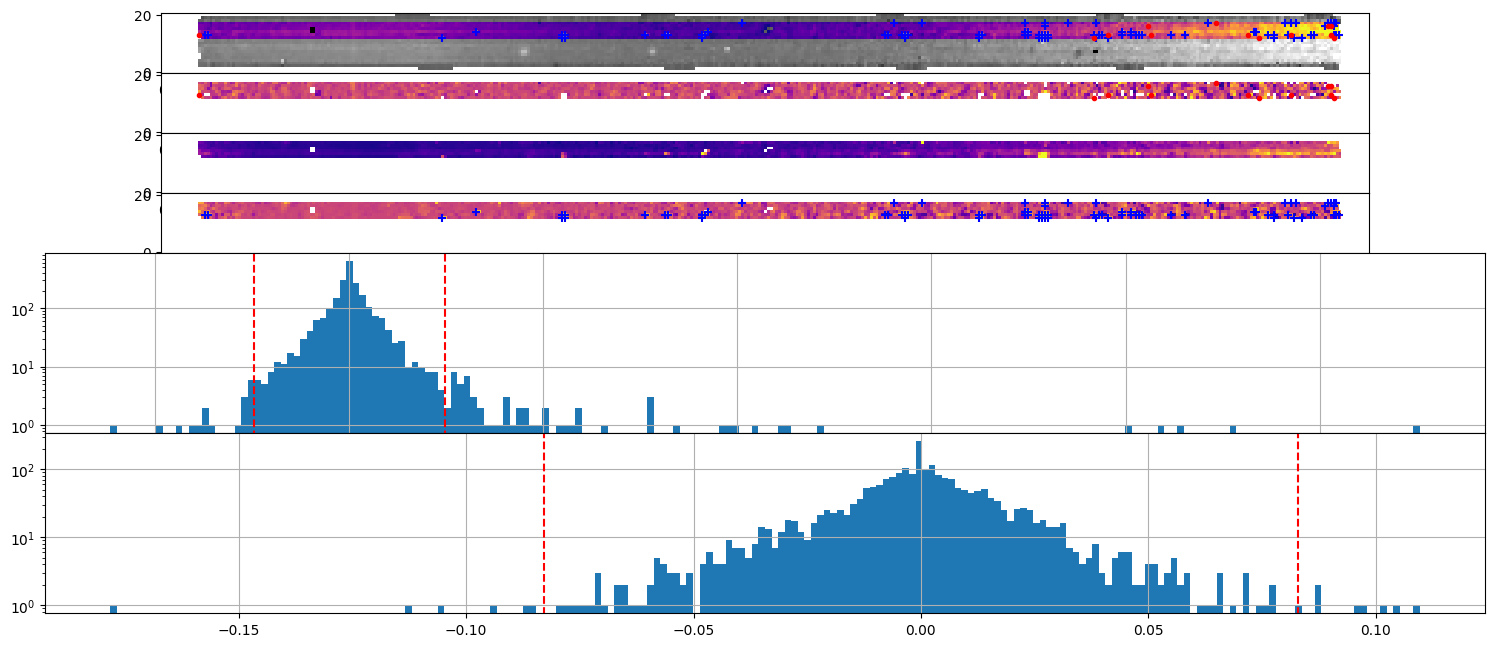

In [6]:
for slit in model.slits:
	if slit.name =="2":
		data = slit.data.copy()
		error = slit.err.copy()
		masking(data,error,source=BBStep.getSourcePosition(slit))

		plt.show()

2024-12-18 16:00:59,473 - stpipe - INFO -  - [BetterBackground]  : Finished Interpolation with 100 iterations, found S = 0.016065802668029167


0 0 1 403 2
1 0 0.5 403 2
2 0 0.25 403 2
3 0 0.125 403 2
4 0 0.0625 403 2
5 0 0.03125 403 2
6 0 0.015625 403 2
7 0 0.0078125 403 2
8 0 0.00390625 403 2
9 0 0.001953125 403 2
10 0 0.0009765625 403 2
11 0 0.00048828125 403 2
12 0 0.000244140625 403 2
13 0 0.0001220703125 403 2
14 0 6.103515625e-05 403 16
15 3.0517578125e-05 6.103515625e-05 93 16
16 3.0517578125e-05 4.57763671875e-05 93 34
17 3.814697265625e-05 4.57763671875e-05 47 34
18 3.814697265625e-05 4.1961669921875e-05 47 36
19 3.814697265625e-05 4.00543212890625e-05 47 37
20 3.910064697265625e-05 4.00543212890625e-05 45 37
21 3.9577484130859375e-05 4.00543212890625e-05 41 37
22 3.981590270996094e-05 4.00543212890625e-05 41 37
23 3.981590270996094e-05 3.993511199951172e-05 41 37
24 3.981590270996094e-05 3.987550735473633e-05 41 37
25 3.984570503234863e-05 3.987550735473633e-05 41 37
26 3.986060619354248e-05 3.987550735473633e-05 41 37
27 3.986060619354248e-05 3.9868056774139404e-05 41 37
28 3.986433148384094e-05 3.9868056774139404e

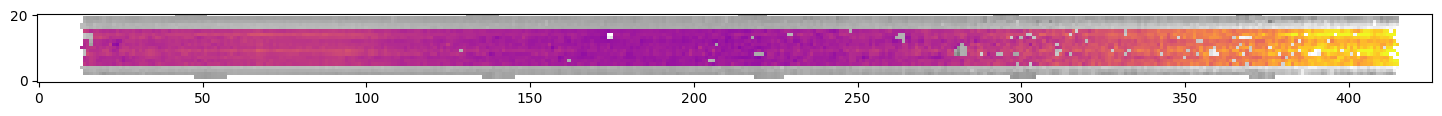

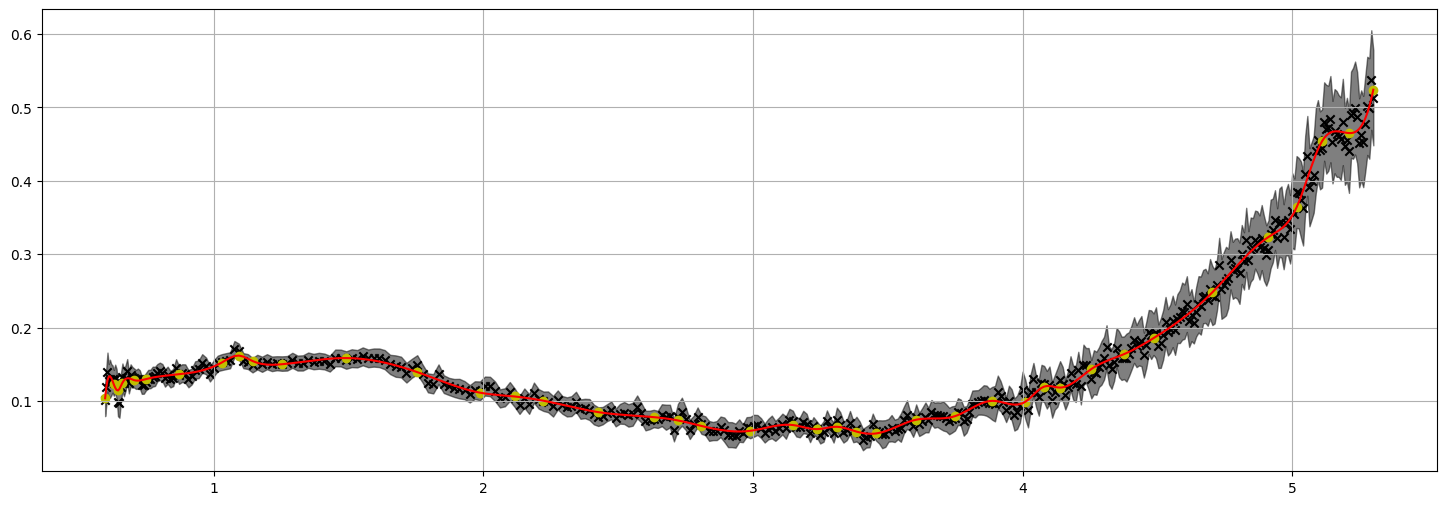

In [12]:
slit = model.slits[2]
data = slit.data.copy()
error = slit.err.copy()

mask = BBStep.cleanupImage(data, error, BBStep.getSourcePosition(slit))


z1, z2 = ZScaleInterval().get_limits(data)
plt.figure(figsize=(18,4))
plt.imshow(data, origin='lower', cmap='grey', interpolation='none', vmin=z1, vmax=z2, alpha=0.5)
data[mask] = np.nan
plt.imshow(data, origin='lower', cmap='plasma', interpolation='none', vmin=z1, vmax=z2)

Y, X = np.indices(slit.data.shape)
_, _, wavelength = slit.meta.wcs.transform("detector", "world", X, Y)
x,y,dy = BBStep.getDataWithMask(data, error, wavelength, BBStep.getSourcePosition(slit))
# Weights, as a fraction of total sum, else it breaks the fitting
w = 1/dy
w /= w.mean()

interp = BBStep.makeInterpolation(x,y,w, n=0.1)

plt.figure(figsize=(18,6))
plt.grid()
plt.scatter(x,y,c='k',marker='x')
plt.fill_between(x,y+dy,y-dy,color='k',alpha=0.5)
plt.plot(x,interp(x),color='r')
plt.scatter(interp.get_knots(),interp(interp.get_knots()),color='y')

plt.show()

In [31]:
s2d_BNBG = "jw01345-o063_s000000002_nirspec_clear-prism_s2d.fits"
path = "./"
s2d = dm.open(s2d_BNBG)
x1d = dm.open(s2d_BNBG.replace("s2d","x1d"))


In [25]:
s2d.info(max_rows=None)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.5.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://asdf-format.org/core/extensions/core-1.5.0
│   │ ├─manifest_software (Software)
│   │ │ ├─name (str): asdf_standard
│   │ │ └─version (str): 1.1.1
│   │ └─software (Software)
│   │   ├─name (str): asdf
│   │   └─version (str): 3.5.0
│   ├─[1] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (str): asdf://astropy.org/astropy/extensions/units-1.0.0
│   │ └─software (Software)
│   │   ├─name (str): asdf-astropy
│   │   └─version (str): 0.7.0
│   ├─[2] (ExtensionMetadata)
│   │ ├─extension_class (str): asdf.extension._manifest.ManifestExtension
│   │ ├─extension_uri (s

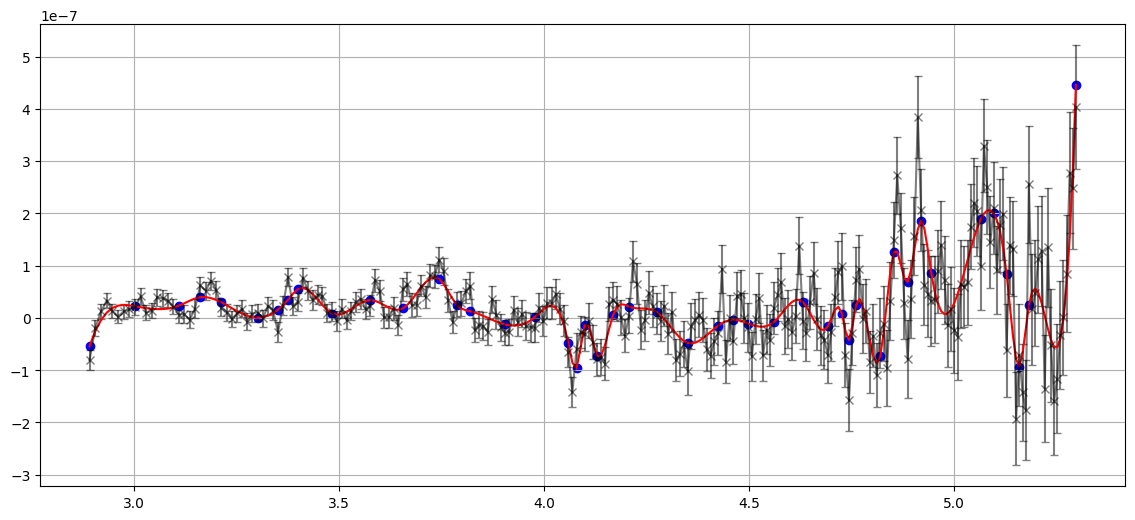

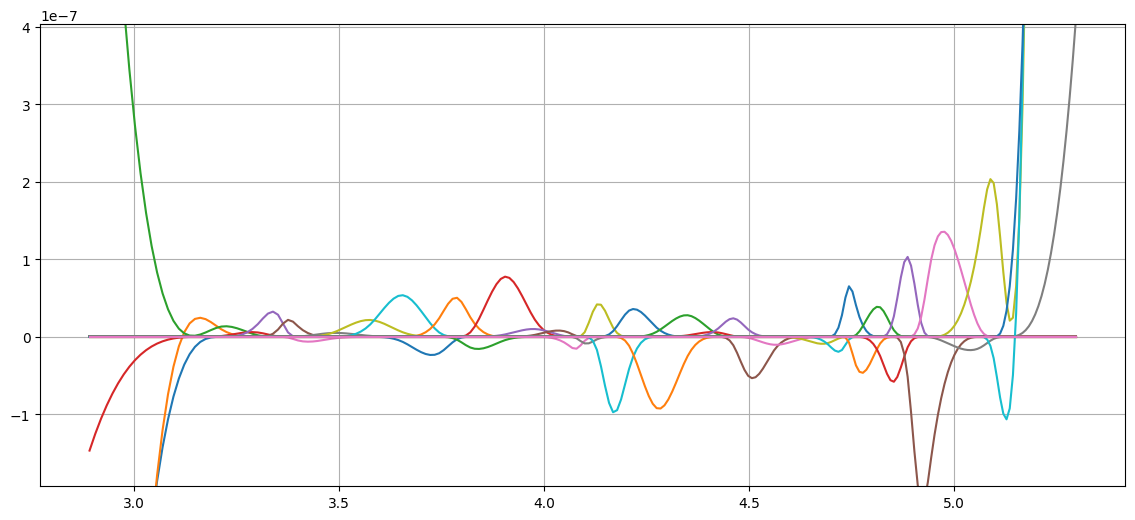

In [112]:
from scipy.interpolate import splev, BSpline

x = x1d.spec[0].spec_table["WAVELENGTH"]
y = x1d.spec[0].spec_table["FLUX"]
dy = x1d.spec[0].spec_table["FLUX_ERROR"]

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(dy)
x = x[mask]
y = y[mask]
dy = dy[mask]

interp = UnivariateSpline(x,y,w=1/dy,s=len(x))
Y = interp(x)

plt.figure(figsize=(14,6))
plt.errorbar(x,y,yerr=dy,capsize=3,color='k',alpha=0.5,marker='x')
plt.grid()
plt.plot(x,Y,color='r')
plt.scatter(interp.get_knots(),interp(interp.get_knots()),color='b')

# Retrieve the spline parameters
knots = interp.get_knots()     # Knots of the spline
coeffs = interp.get_coeffs()   # Coefficients of the spline
degree = 3  # Degree of the spline

plt.show()

plt.figure(figsize=(14,6))


for i in range(len(coeffs)):
	coeffs_single = np.zeros_like(coeffs)
	coeffs_single[i] = coeffs[i]  # Isolate a single coefficient
	basis_function = BSpline(knots, coeffs_single, degree)
	y_eval = basis_function(x)
	plt.plot(x,y_eval)

plt.grid()
plt.ylim(y.min(),y.max())

plt.show()

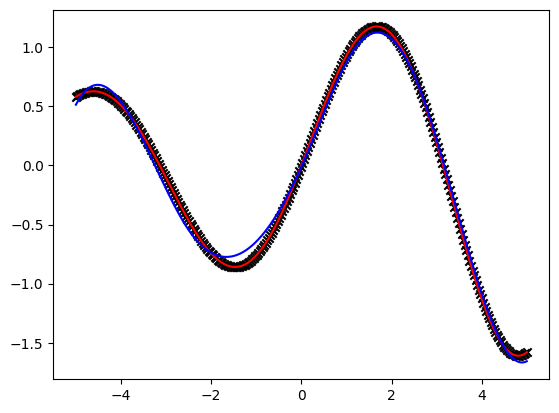

30 12


In [29]:
from scipy.interpolate import make_splrep, make_lsq_spline
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5,5,300)
s = 0.1
y = np.sin(x)*np.exp(s*x) + 0*np.random.normal(0,0.05,len(x))
w = np.zeros_like(x)
n = 0.1
interp = make_splrep(x, y, k=3, s=1, nest=int(n*len(x)))

plt.figure()
plt.scatter(x,y,color='k',marker='x')
plt.plot(x,np.sin(x)*np.exp(s*x),color='r',label='True')
plt.plot(x,interp(x),color='b',label='Interpolated')
plt.show()

print(int(n*len(x)), len(interp.t))